In [1]:
import numpy as np
import matplotlib.pyplot as plt
import RF_Track
import re


RF-Track, version 2.5.4

Copyright (C) 2016-2025 CERN, Geneva, Switzerland. All rights reserved.

Author and contact:
 Andrea Latina <andrea.latina@cern.ch>
 BE-ABP Group
 CERN
 CH-1211 GENEVA 23
 SWITZERLAND

This software is distributed under a CERN proprietary software
license in the hope that it will be useful, but WITHOUT ANY WARRANTY;
not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

See the COPYRIGHT and LICENSE files at the top-level directory of
the RF-Track download area: https://gitlab.cern.ch/rf-track

RF-Track was compiled with GSL-2.8 and fftw-3.3.10



[RF-Track] Could not check for updates.


## Beam and Lattice parameters

In [2]:
# Beam parameters
mass = RF_Track.electronmass    # particle mass in MeV/c^2
population = 300 * RF_Track.pC               # number of particles per bunch
Q = -1                          # particle charge in e units
P_ref = 198                     # reference momentum in MeV/c

freq = 2.997e9                  # Hz

In [3]:
### Lattice parameters
Ldrift = 1 # m
Lquad = 0.226  # magnetic length of the quadrupole in m
nominal_K = 0.7752883624676146 #3.35  # 1/m

In [4]:
# Creating an essential beamline

# Integral Transfer Function
def get_ITF(I):
    return 1.29404711e-2  - 2.59458259e-07*I # T/A

def get_grad(I, Lquad):
    G_0 = I * get_ITF(I) / Lquad    # T/m
    return G_0

def get_Quad_K(G_0, P_ref):
    K = 299.8 *G_0 / P_ref  # 1/m^2
    return K

def get_Quad_K_from_I(I, Lquad, P_ref):
    G_0 = get_grad(I, Lquad)
    K = get_Quad_K(G_0, P_ref)
    return K


In [5]:
def get_lattice(Iquad):
    G0 = get_grad(Iquad, Lquad) # T / m
    K1 = get_Quad_K(G0, P_ref) # 1 / M^2

    # A full, focusing quadrupole
    Quad=RF_Track.Quadrupole(Lquad, P_ref/Q, K1) # last parameter is K in 1/m2

    # The Drift
    Dr = RF_Track.Drift(Ldrift)
    Dr.set_tt_nsteps(100)

    # The Screen

    S = RF_Track.Screen()

    # Defining the sequence

    Beamline=RF_Track.Lattice()
    Beamline.append(Quad)
    Beamline.append(Dr)
    Beamline.append(S)
    print(Beamline.get_length())
    return Beamline

## TWISS PARAMETERS: Insertion, tracking and check

In [6]:
# Twiss parameters
# They have to be inserted here
# They are the ones at the starting point of your constructed lattice

Twiss = RF_Track.Bunch6d_twiss()

Twiss.beta_x = 15.6        # m
Twiss.beta_y = 24 # 2.73        # m
Twiss.alpha_x = -0.49
Twiss.alpha_y = -3.65 # 0.339
Twiss.emitt_x = 7.04     # mm.mrad normalised emittance
Twiss.emitt_y = 3.39 # 0.727      # mm.mrad
# Twiss.sigma_t = 10 * RF_Track.ps       # mm/c   or 37 * RF_Track.ps
# Twiss.sigma_pt = 10     # permille
Twiss.mean_xp = 0.0
Twiss.mean_yp = 0.0

In [7]:
# Setup
N = 10000
B0 = RF_Track.Bunch6d(mass, population, Q, P_ref, Twiss, N)             # reference bunch

# n_bunches = 1
# bunch_spacing = 0.0 * RF_Track.ns # mm/c

# B0 = RF_Track.Beam(n_bunches, Bunch, bunch_spacing)

In [8]:
def get_Twiss(Bunch):
    I0 = Bunch.get_info()
    pos0 = I0.S
    beta_x = I0.beta_x
    beta_y = I0.beta_y
    alpha_x = I0.alpha_x
    alpha_y = I0.alpha_y
    emitt_x = I0.emitt_x
    emitt_y = I0.emitt_y
    sigma_t = I0.sigma_t
    sigma_pt = I0.sigma_pt
    sigma_x = I0.sigma_x
    sigma_y = I0.sigma_y
    mean_x = I0.mean_x
    mean_y = I0.mean_y
    mean_xp = I0.mean_xp
    mean_yp = I0.mean_yp
    return pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp

def print_Twiss(Bunch):
    pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp = get_Twiss(Bunch)
    print(f"Position: {pos0:.2f} m")
    print(f"beta_x: {beta_x:.2f} m")
    print(f"beta_y: {beta_y:.2f} m")
    print(f"alpha_x: {alpha_x:.2f}")
    print(f"alpha_y: {alpha_y:.2f}")
    print(f"emittance_x: {emitt_x:.2f} mm.mrad")
    print(f"emittance_y: {emitt_y:.2f} mm.mrad")
    print(f"sigma_t: {sigma_t:.2f} mm/c")
    print(f"sigma_pt: {sigma_pt:.2f} permille")
    print(f"sigma_x: {sigma_x:.2f} mm")
    print(f"sigma_y: {sigma_y:.2f} mm")
    print(f"mean_x: {mean_x:.2f} mm")
    print(f"mean_y: {mean_y:.2f} mm")
    print(f"mean_xp: {mean_xp:.2f} mrad")
    print(f"mean_yp: {mean_yp:.2f} mrad")


In [9]:
Iquad = 20 # A
Beamline = get_lattice(Iquad)
B1 = Beamline.track(B0)
print("Initial Twiss parameters:")
print_Twiss(B0)

1.226
Initial Twiss parameters:
Position: 0.00 m
beta_x: 15.36 m
beta_y: 23.95 m
alpha_x: -0.48
alpha_y: -3.64
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 0.53 mm
sigma_y: 0.46 mm
mean_x: -0.00 mm
mean_y: -0.00 mm
mean_xp: -0.00 mrad
mean_yp: 0.00 mrad


In [10]:
print("Final Twiss parameters:")
print_Twiss(B1)

Final Twiss parameters:
Position: 1.23 m
beta_x: 5.75 m
beta_y: 64.14 m
alpha_x: 3.25
alpha_y: -21.85
emittance_x: 7.04 mm.mrad
emittance_y: 3.39 mm.mrad
sigma_t: 0.00 mm/c
sigma_pt: 0.00 permille
sigma_x: 0.32 mm
sigma_y: 0.75 mm
mean_x: 0.00 mm
mean_y: -0.00 mm
mean_xp: 0.00 mrad
mean_yp: -0.00 mrad


## Transport Table getting, followed by phase space extraction

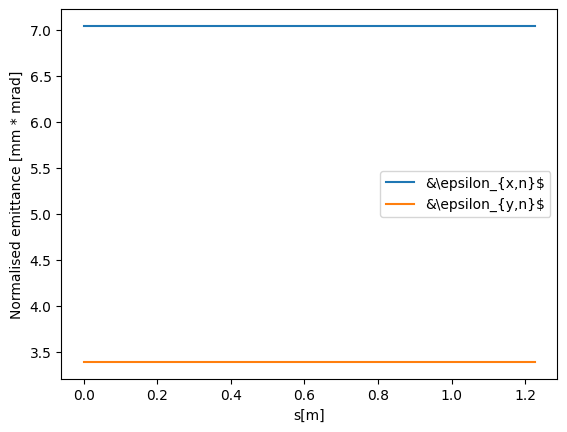

In [11]:
T = Beamline.get_transport_table('%S %emitt_x %emitt_y')
plt.figure()
plt.plot(T[:,0], T[:,1], label = r'&\epsilon_{x,n}$')
plt.plot(T[:,0], T[:,2], label = r'&\epsilon_{y,n}$')
plt.xlabel('s[m]')
plt.ylabel('Normalised emittance [mm * mrad]')
plt.legend()
plt.show()

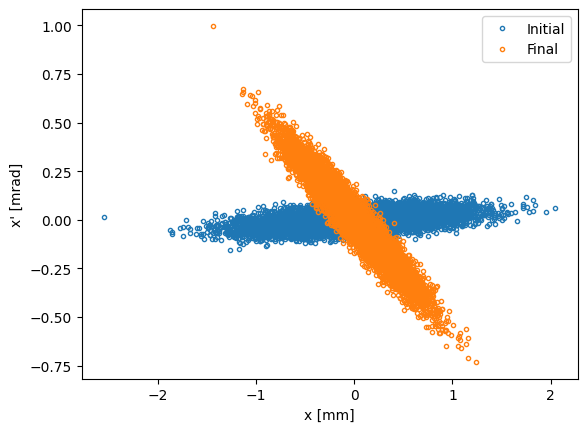

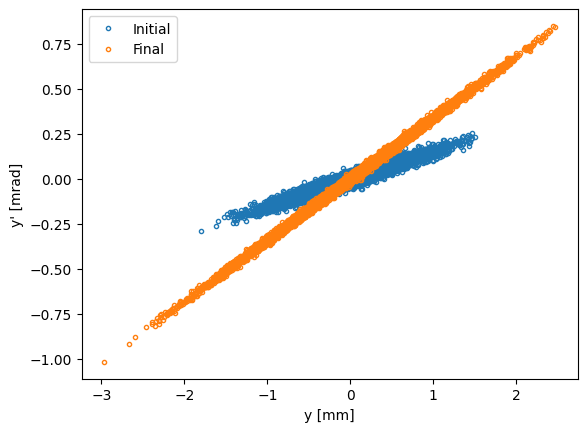

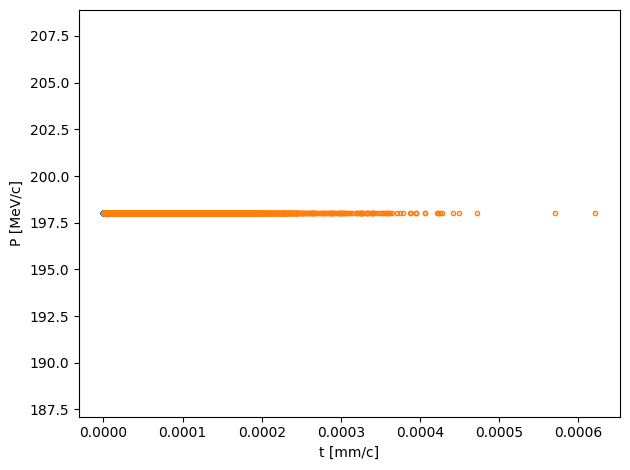

In [12]:
# Phase Space: Initial and Final

M0 = B0.get_phase_space ('%x %xp %y %yp %dt %P')
M1 = B1.get_phase_space ('%x %xp %y %yp %dt %P')

plt.figure()
plt.plot(M0[:,0], M0[:,1], '.', label='Initial', mfc='none')
plt.plot(M1[:,0], M1[:,1], '.', label='Final', mfc='none')
plt.xlabel('x [mm]')
plt.ylabel("x' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,2], M0[:,3], '.', label='Initial', mfc='none')
plt.plot(M1[:,2], M1[:,3], '.', label='Final', mfc='none')
plt.xlabel('y [mm]')
plt.ylabel("y' [mrad]")
plt.legend()

plt.figure()
plt.plot(M0[:,4], M0[:,5], '.', label='Final', mfc='none')
plt.plot(M1[:,4], M1[:,5], '.', label='Final', mfc='none')
plt.xlabel('t [mm/c]')
plt.ylabel('P [MeV/c]')
plt.tight_layout()

# T = L.get_transport_table('%S %sigma_x %sigma_y %sigma_t %sigma_E %mean_E %emitt_x %emitt_y')

1.226
1.226
1.226
1.226
1.226
1.226
1.226
1.226
1.226
1.226
1.226


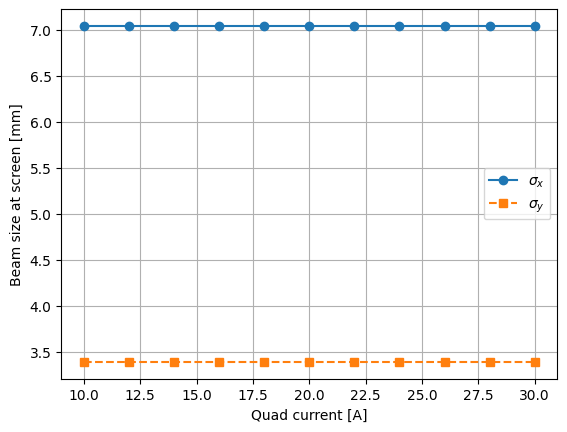

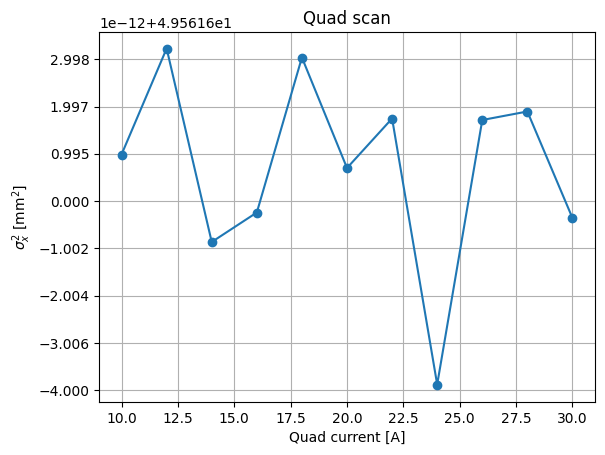

In [13]:
currents = np.linspace(10, 30, 11)
sigma_x = []
sigma_y = []

for I in currents:
    L = get_lattice(I)
    B = L.track(B0)
    T = L.get_transport_table('%S %emitt_x %emitt_y')
    sigma_x.append(T[-1,1]) # sigma x at screen, m
    sigma_y.append(T[-1,2]) # sigma y at screen, m
sigma_x=np.array(sigma_x)
sigma_y=np.array(sigma_y)

plt.figure()
plt.plot(currents, sigma_x, 'o-', label=r'$\sigma_x$')
plt.plot(currents, sigma_y, 's--', label=r'$\sigma_y$')
plt.xlabel('Quad current [A]')
plt.ylabel('Beam size at screen [mm]')
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(currents, sigma_x**2, 'o-')
plt.xlabel('Quad current [A]')
plt.ylabel(r'$\sigma_x^2$ [mm$^2$]')
plt.title('Quad scan')
plt.grid(True)
plt.show()

## QUAD SCANS Tool

In [14]:
def R_matrix(B0, B1):
    M0 = B0.get_phase_space('%x %xp %y %yp %dt %pt')
    M1 = B1.get_phase_space('%x %xp %y %yp %dt %pt')

    x0  = M0[:,0]
    xp0 = M0[:,1]
    y0  = M0[:,2]
    yp0 = M0[:,3]
    t0  = M0[:,4]
    d0  = M0[:,5]

    x1  = M1[:,0]
    xp1 = M1[:,1]
    y1  = M1[:,2]
    yp1 = M1[:,3]
    t1  = M1[:,4]
    d1  = M1[:,5]

    I = np.ones(x0.size)
    I1 = np.array([x1,xp1,y1,yp1,t1,d1]).T
    I0 = [I, # K - 0th order
      x0,xp0,y0,yp0,t0,d0, # R - 1st order
      x0**2,xp0**2,y0**2,yp0**2,t0**2,d0**2, # T 2nd-order
      x0*xp0,x0*y0,x0*yp0,x0*t0,x0*d0, # T
      xp0*y0,xp0*yp0,xp0*t0,xp0*d0, # T
      y0*yp0,y0*t0,y0*d0, # T
      yp0*t0,yp0*d0, # T
      t0*d0, # T
      d0*d0*d0,d0*d0*t0,d0*d0*x0,d0*d0*xp0,d0*d0*y0, # U - 3rd order
      d0*d0*yp0,d0*t0*t0,d0*t0*x0,d0*t0*xp0,d0*t0*y0, # U
      d0*t0*yp0,d0*x0*x0,d0*x0*xp0,d0*x0*y0,d0*x0*yp0, # U
      d0*xp0*xp0,d0*xp0*y0,d0*xp0*yp0,d0*y0*y0, # U
      d0*y0*yp0,d0*yp0*yp0,t0*t0*t0,t0*t0*x0,t0*t0*xp0, # U
      t0*t0*y0,t0*t0*yp0,t0*x0*x0,t0*x0*xp0,t0*x0*y0, # U
      t0*x0*yp0,t0*xp0*xp0,t0*xp0*y0,t0*xp0*yp0, # U
      t0*y0*y0,t0*y0*yp0,t0*yp0*yp0,x0*x0*x0,x0*x0*xp0, # U
      x0*x0*y0,x0*x0*yp0,x0*xp0*xp0,x0*xp0*y0, # U
      x0*xp0*yp0,x0*y0*y0,x0*y0*yp0,x0*yp0*yp0, # U
      xp0*xp0*xp0,xp0*xp0*y0,xp0*xp0*yp0,xp0*y0*y0, # U
      xp0*y0*yp0,xp0*yp0*yp0,y0*y0*y0,y0*y0*yp0, # U
      y0*yp0*yp0,yp0*yp0*yp0] # U
    I0 = np.array(I0).T

    M = np.linalg.lstsq(I0, I1, rcond=None)[0].T
    K = M[:,0]
    R = M[:,1:7]
    T = M[:,7:28]
    U = M[:,28:]   

    K.shape, R.shape, T.shape

    # Full tracking matrix
    MT = np.concatenate((K.reshape(6,1), R, T, U), axis=1)
    I1_predicted = (MT @ I0.T).T

    return R

In [15]:
def phase_advance(R, beta_i, beta_f, alpha_i, alpha_f):
    """
    Calculate phase advance from R matrix and Twiss parameters.
    
    Parameters:
        R: 2x2 matrix
        beta_i, beta_f: initial and final beta functions
        alpha_i, alpha_f: initial and final alpha functions
    
    Returns:
        phi_rad: phase advance in radians
        phi_deg: phase advance in degrees
    """
    sin_phi = R[0, 1] / np.sqrt(beta_f * beta_i)
    cos_phi = R[0, 0] * np.sqrt(beta_i / beta_f) - alpha_i * sin_phi
    phi_rad = np.arcsin(sin_phi)  # in radians
    phi_deg = np.rad2deg(phi_rad)  # in degrees
    
    return phi_rad, phi_deg

In [16]:
### QUAD SCANS ###

def run_quad_scan(quad_index: int,
    current_range: np.ndarray,
    B0,
    quad_currents: list,
    P_ref: float,
    get_Quad_K_from_I,
    get_lattice,
    get_Twiss,
    target_ratio: float = None,
    tolerance: float = 0.05,
    max_iter: int = 100):
    """
    Run a quadrupole scan by varying the current of a single quadrupole and tracking beam size at the screen.

    Parameters:
    - quad_index: Index of the quadrupole to scan.
    - current_range: Array of current values to scan.
    - B0: Initial beam object.
    - quad_currents: List of all quadrupole currents.
    - Q_polarity: List of polarities for all quadrupoles.
    - Lquad: Length of each quadrupole [m].
    - P_ref: Reference momentum [eV/c].
    - Q: Particle charge [e].
    - get_Quad_K_from_I: Function to convert current to K1.
    - get_lattice: Function that returns the lattice, accepts K1_override.
    - get_Twiss: Function to compute Twiss parameters.
    - target_ratio: Desired waist/arms sigma ratio (e.g., 0.5). If None, no constraint is applied.
    - tolerance: Allowed deviation for the ratio.
    - max_iter: Maximum iterations to adjust current_range.


    Returns:
    - currents: List of scanned currents.
    - sigma_x_at_screen: Beam size in x at screen.
    - sigma_y_at_screen: Beam size in y at screen.
    """
    import copy

    transport_tables = []
    currents = []
    sigma_x_at_screen = []
    sigma_y_at_screen = []
    lines_in_phase_space_x = []
    lines_in_phase_space_y = []
    phi_x_deg_list = []
    phi_y_deg_list = []



    for current in current_range:
        print(f'Current: {current:.2f} A')
        quad_currents[quad_index] = current

        # Build lattice
        L = get_lattice('CA.QFD0350', 'CA.BTV0910', P_ref, quad_currents)
        # L.append(RF_Track.Drift(1.0))
        length = L.get_length()

        beta_ix, alpha_ix = B0.get_info().beta_x, B0.get_info().alpha_x
        beta_iy, alpha_iy = B0.get_info().beta_y, B0.get_info().alpha_y

        # Track and Unpack Twiss parameters
        B1 = L.track(B0)
        pos0, beta_x, beta_y, alpha_x, alpha_y, emitt_x, emitt_y, sigma_t, sigma_pt, sigma_x, sigma_y, mean_x, mean_y, mean_xp, mean_yp = get_Twiss(B1)

        R = R_matrix(B0, B1)
        phi_x_rad, phi_x_deg = phase_advance(R, beta_ix, beta_x, alpha_ix, alpha_x)
        phi_y_rad, phi_y_deg = phase_advance(R, beta_iy, beta_y, alpha_iy, alpha_y)

        phi_x_deg_list.append(phi_x_deg)
        phi_y_deg_list.append(phi_y_deg)

        # Compute phase-space slopes
        slope_x = -np.cos(phi_x_deg) / np.sin(phi_x_deg)
        slope_y = -np.cos(phi_y_deg) / np.sin(phi_y_deg)
        k_x = sigma_x / np.sqrt(beta_x * emitt_x)
        k_y = sigma_y / np.sqrt(beta_y * emitt_y)
        b_x = k_x / np.sin(phi_x_deg)
        b_y = k_y / np.sin(phi_y_deg)


        lines_in_phase_space_x.append((current, slope_x, b_x, beta_x, alpha_x, emitt_x))
        lines_in_phase_space_y.append((current, slope_y, b_y, beta_y, alpha_y, emitt_y))

        # Store transport table
        T = L.get_transport_table('%S %sigma_x %sigma_y %beta_x %beta_y %alpha_x %alpha_y %mean_x %mean_y %mean_xp %mean_yp')
        transport_tables.append((current, copy.deepcopy(T)))

        # Extract beam sizes at screen
        currents = []
        sigma_x_at_screen = []
        sigma_y_at_screen = []
        for current, T in transport_tables:
            currents.append(current)
            sigma_x_at_screen.append(T[-1, 1])  # σₓ at screen
            sigma_y_at_screen.append(T[-1, 2])  # σᵧ at screen

    return transport_tables, currents, sigma_x_at_screen, sigma_y_at_screen, lines_in_phase_space_x, lines_in_phase_space_y, length, phi_x_deg_list, phi_y_deg_list

In [17]:
current_range = np.linspace(36, 43, 40)
quad_index = 4  # QDD515

transport_tables, currents, sigma_x, sigma_y, phase_space_x, phase_space_y, length, phi_x_deg, phi_y_deg = run_quad_scan(
    quad_index=quad_index,
    current_range=current_range,
    B0=B0,
    quad_currents=0,
    P_ref=P_ref,
    get_Quad_K_from_I=get_Quad_K_from_I,
    get_lattice=Beamline,
    get_Twiss=get_Twiss,
    # target_ratio=0.5,
    # tolerance=0.05,
    # max_iter=100
)


print(length)
# L.get_length()

Current: 36.00 A


TypeError: 'int' object does not support item assignment

In [ ]:
# Find the minimum sigma index (assumed waist)
idx_min = np.argmin(sigma_x)
_, _, _, beta0, alpha0, eps0 = phase_space_x[idx_min]

# Ellipse parameters
gamma0 = (1 + alpha0**2) / beta0

# Generate reference ellipse from β, α, ε at waist (normalized units)
theta = np.linspace(0, 2 * np.pi, 500)
x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
ellipse = np.vstack([x_ellipse, xp_ellipse])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*ellipse, lw=2, color='red', label='Reconstructed ellipse (min σ)')

for (I, m, _, _, _, _), phi_deg in zip(phase_space_x, phi_x_deg):
    m = float(m)

    # Compute intercept b of the line tangent to the reference ellipse
    # Based on: b = sqrt(ε * (β m² + 2α m + γ))
    b_sq = eps0 * (beta0 * m**2 + 2 * alpha0 * m + gamma0)
    if b_sq < 0:
        continue  # skip unphysical
    b = np.sqrt(b_sq)

    # Plot both +b and -b tangents
    x_vals = np.linspace(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0), 2)
    ax.plot(x_vals, m * x_vals + b, color='black', alpha=0.3)
    ax.plot(x_vals, m * x_vals - b, color='blue', alpha=0.3)

# Formatting
ax.set_xlabel("x [√ε]")
ax.set_xlim(-1.5 * np.sqrt(eps0 * beta0), 1.5 * np.sqrt(eps0 * beta0))
ax.set_ylim(-8 * np.sqrt(eps0 / beta0), 8 * np.sqrt(eps0 / beta0))
ax.set_ylabel("x' [√ε]")
ax.set_title("Phase space ellipse with tg lines")
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.show()


## Plotting (Quad Scans)

In [ ]:
def plot_sigma_vs_pos(
    transport_tables, 
    quad_index=4, 
    quad_label="QDD515"
):
    """
    Plots σ_x and σ_y along s from a list of transport tables.

    Parameters:
    - transport_tables: list of (current, transport_table) tuples
    - quad_index: index of scanned quadrupole (used for title)
    - quad_label: label of the quadrupole for title and legend
    - unit_scale: scale to convert σ from m to mm (default: 1e3)
    """
    
    plt.figure(figsize=(10, 6))
    for current, T in transport_tables:
        plt.plot(T[:, 0], T[:, 1], label=rf'$\sigma_x$ (I={current:.1f} A)', linewidth=1.5)
    plt.xlabel('s [m]')
    plt.ylabel(r'$\sigma_x$ [mm]')
    plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_x$')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8, ncol=2)
    plt.tight_layout(rect=[0,0,0.8,1])
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    for current, T in transport_tables:
        plt.plot(T[:, 0], T[:, 2], '--', label=rf'$\sigma_y$ (I={current:.1f} A)', linewidth=1.5)
    plt.xlabel('s [m]')
    plt.ylabel(r'$\sigma_y$ [mm]')
    plt.title(f'Quad {quad_index} scan ({quad_label}), $\sigma_y$')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8, ncol=2)
    plt.tight_layout(rect=[0,0,0.8,1])
    plt.grid(True)
    plt.show()


In [ ]:
plot_sigma_vs_pos(transport_tables, quad_index=4, quad_label="QDD515")

In [ ]:
def plot_sigma_vs_current(
    currents,
    sigma_x,
    sigma_y,
    quad_label="QDD515"
):
    """
    Plots sigma_x and sigma_y at the screen vs quadrupole current.

    Parameters:
    - currents: list of quadrupole current values [A]
    - sigma_x: list of σ_x values at the screen [m]
    - sigma_y: list of σ_y values at the screen [m]
    - quad_label: name of the scanned quadrupole for titles
    - unit_scale: scale to convert σ from m to mm (default: 1e3)
    """
    
    # Plot sigma_x
    plt.figure(figsize=(8, 5))
    plt.plot(currents, [s for s in sigma_x], 'o-', linewidth=2, label=r'$\sigma_x$')
    plt.xlabel('Quad current [A]')
    plt.ylabel(r'$\sigma_x$ at screen [mm]')
    plt.title(rf'$\sigma_x$ vs Current ({quad_label})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

    # Plot sigma_y
    plt.figure(figsize=(8, 5))
    plt.plot(currents, [s for s in sigma_y], 's--', linewidth=2, color='orange', label=r'$\sigma_y$')
    plt.xlabel('Quad current [A]')
    plt.ylabel(r'$\sigma_y$ at screen [mm]')
    plt.title(rf'$\sigma_y$ vs Current ({quad_label})')
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()


In [ ]:
plot_sigma_vs_current(
    currents,
    sigma_x,
    sigma_y,
    quad_label="QDD515"
)


In [ ]:
# Find the minimum sigma index (assumed waist)
idx_min = np.argmin(sigma_x)
_, _, _, beta0, alpha0, eps0 = phase_space_x[idx_min]

# Ellipse parameters
gamma0 = (1 + alpha0**2) / beta0

# Generate reference ellipse from β, α, ε at waist (normalized units)
theta = np.linspace(0, 2 * np.pi, 500)
x_ellipse = np.sqrt(eps0 * beta0) * np.cos(theta)
xp_ellipse = -np.sqrt(eps0 / beta0) * (alpha0 * np.cos(theta) + np.sin(theta))
ellipse = np.vstack([x_ellipse, xp_ellipse])

# Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(*ellipse, lw=2, color='red', label='Reconstructed ellipse (min σ)')

for (I, m, _, _, _, _), phi_deg in zip(phase_space_x, phi_x_deg):
    m = float(m)

    # Compute intercept b of the line tangent to the reference ellipse
    # Based on: b = sqrt(ε * (β m² + 2α m + γ))
    b_sq = eps0 * (beta0 * m**2 + 2 * alpha0 * m + gamma0)
    if b_sq < 0:
        continue  # skip unphysical
    b = np.sqrt(b_sq)

    # Plot both +b and -b tangents
    x_vals = np.linspace(-3 * np.sqrt(eps0 * beta0), 3 * np.sqrt(eps0 * beta0), 2)
    ax.plot(x_vals, m * x_vals + b, color='black', alpha=0.3)
    ax.plot(x_vals, m * x_vals - b, color='blue', alpha=0.3)

# Formatting
ax.set_xlabel("x [√ε]")
ax.set_xlim(-1.5 * np.sqrt(eps0 * beta0), 1.5 * np.sqrt(eps0 * beta0))
ax.set_ylim(-8 * np.sqrt(eps0 / beta0), 8 * np.sqrt(eps0 / beta0))
ax.set_ylabel("x' [√ε]")
ax.set_title("Phase space ellipse with tg lines")
ax.set_aspect('equal')
ax.grid(True)
ax.legend()
plt.show()


In [ ]:
min_sigma_y = min(sigma_y)
min_index = sigma_y.index(min_sigma_y)
current_at_min_sigma_y = currents[min_index]
print("sigma_y min:", min_sigma_y)
print("Current at min sigma_y:", current_at_min_sigma_y)

In [ ]:
min_sigma_x = min(sigma_x)
min_index = sigma_x.index(min_sigma_x)
current_at_min_sigma_x = currents[min_index]
print("sigma_x min:", min_sigma_x)
print("Current at min sigma_x:", current_at_min_sigma_x)

In [ ]:
print(phase_space_x)

print(transport_tables)